In [161]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

#### Back to some core ds concepts! This time, gradient boosting. 
We'll do it from scratch, and then eventually use a canned version with regularization. 
Okay, so what's the fuss about gradient boosting then? 
The key points:
- The crux of it: an ensemble of learners. Early generations of learners are weak, and don't do a very good job; later generations improve upon them. Mistakes are learned over generations.
- In boosting, overfitting can happen easily. A proper stopping criterion has to be established to prevent that.
- Models are sequential (supports the idea of learning from previous generation's errors)

#### General Formula:
- use linear regression or random forest to predict. Get residuals
- fit to residuals
- new fit is previous fit + fit to residuals
- rinse and repeat until stopping condition reached:
  
$\epsilon_{n-1} = y - \hat{y}_{n-1}$

$\hat{\epsilon}_{n-1} = f_n(x)$

$\hat{y}_n = \hat{y}_{n-1} + \hat{\epsilon}_{n-1}$

## 1. Gradient boosting with linear regression

4/4 [==============================] - 0s 2ms/step


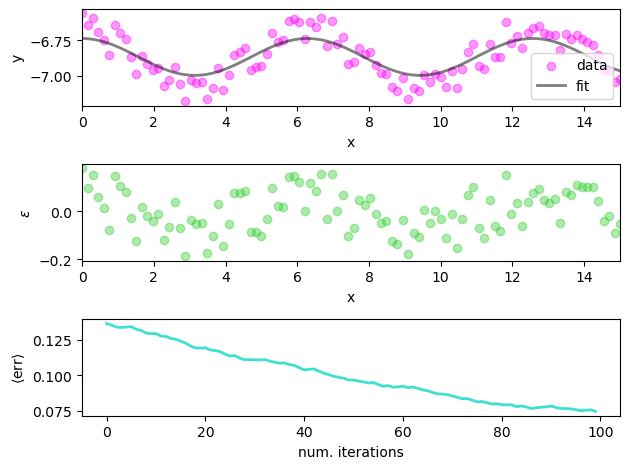

In [133]:
x = np.linspace(0, 15, 100)
y = np.array([.25*np.random.random() + .2 * np.cos(x_i) - 7. for x_i in x])

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

#for step 0, we'll start with just a constant value. Aka a really shit model
y_pred = np.mean(y)*np.ones_like(y) 
res = y-y_pred

nmax = 100 #we probably want to see a max number of iterations beyond which we'll give up
tolerance = 5e-2
lr = 0.01
convergence = []

for iteration in range(nmax):

    model = tf.keras.Sequential([tf.keras.layers.Input(shape=(1,)), tf.keras.layers.Dense(1)]) #can do random forest or linear regression, etc.
        #here, it's a one layer neural net, which is just a linear regression
    model.compile(optimizer='sgd', loss='mse')
    
    model.fit(np.cos(x), res, epochs=50, verbose=0) #fit to residuals
    y_pred += lr*model.predict(np.cos(x))
    res = y-y_pred
    
    err = np.mean(np.abs(res))
    convergence.append(err)
    
    if err < tolerance:
        break

fig, axs = plt.subplots(3, sharex=False)

w, b = model.layers[0].get_weights()
slope = w[0][0]
intercept = b[0]

ax = axs[0]
ax.scatter(x, y, marker='o', alpha=0.4, color='fuchsia', label='data')
ax.plot(x, y_pred, color='k', linewidth=2, alpha=0.5, label='fit')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

ax = axs[1]
ax.scatter(x, res, marker='o', alpha=0.4, color='limegreen')
ax.set_xlabel('x')
ax.set_ylabel(r'$\epsilon$')

ax = axs[2]
ax.plot(range(len(convergence)), convergence, linestyle='-', linewidth=2, color='turquoise')
ax.set_xlabel('num. iterations')
ax.set_ylabel(r'$\langle$err$\rangle$')

for ax in [axs[0], axs[1]]:
    ax.set_xlim([0, 15])

plt.tight_layout()
plt.show()

## 2. Gradient boosting with random forest regression

#### gradient boosting is typically implemented with random forest in mind, so let's go ahead and do that instead of a single-layer perceptron/linear regressor

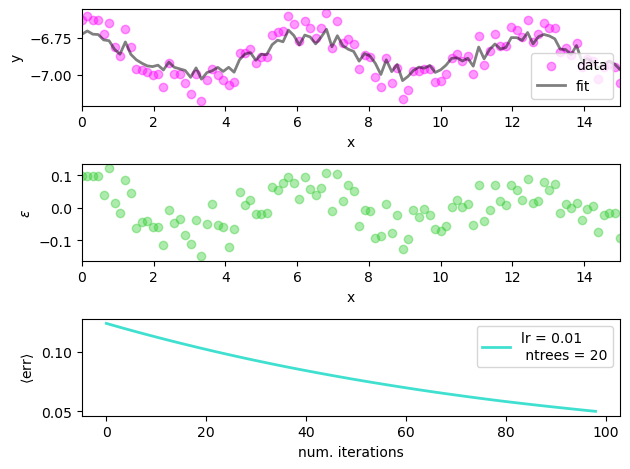

In [135]:
def gboost(x, y, ntrees, lr, tol):
    '''a couple of hyperparameters can be used as arguments. 
    - ntrees: number of decision trees in forest
    - lr: the learning rate
    - tol: tolerance used for early stopping in this case. Once error < tol, we stop'''
    
    x = x.reshape(-1, 1)
    y = y.ravel()  
    
    y_pred = np.mean(y) * np.ones_like(y)
    res = y - y_pred
    
    nmax = 100  
    convergence = []
    
    for iteration in range(nmax):
        x_cos = np.cos(x).reshape(-1, 1)  
        
        regressor = RandomForestRegressor(n_estimators=ntrees, random_state=0, oob_score=True)
        regressor.fit(x_cos, res)
        err_pred = regressor.predict(x_cos).ravel()  
        y_pred = lr * err_pred + y_pred  
        res = y - y_pred
        
        err = np.mean(np.abs(res))
        convergence.append(err)
        
        if err < tolerance:
            break
    
    fig, axs = plt.subplots(3, sharex=False)
    
    ax = axs[0]
    ax.scatter(x, y, marker='o', alpha=0.4, color='fuchsia', label='data')
    ax.plot(x, y_pred, color='k', linewidth=2, alpha=0.5, label='fit')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    
    ax = axs[1]
    ax.scatter(x, res, marker='o', alpha=0.4, color='limegreen')
    ax.set_xlabel('x')
    ax.set_ylabel(r'$\epsilon$')
    
    ax = axs[2]
    ax.plot(range(len(convergence)), convergence, linestyle='-', linewidth=2, color='turquoise', label = f'lr = {lr}\n ntrees = {ntrees}')
    ax.set_xlabel('num. iterations')
    ax.set_ylabel(r'$\langle$err$\rangle$')
    ax.legend()
    
    for ax in [axs[0], axs[1]]:
        ax.set_xlim([0, 15])
    
    plt.tight_layout()
    plt.show()


#run it!
x = np.linspace(0, 15, 100)
y = np.array([.25*np.random.random() + .2 * np.cos(x_i) - 7. for x_i in x])

gboost(x, y, ntrees=20, lr=.01, tol=5e-2)

#### as you can see random forest is somewhat prone to overfitting! Let's try again with different hyperparameters. 
maybe slower learning rate?

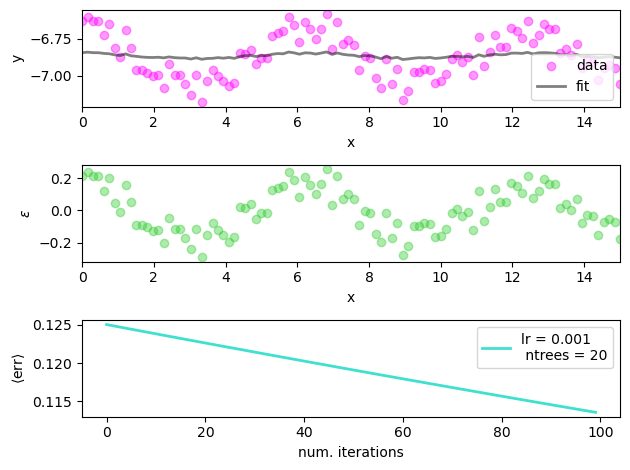

In [136]:
gboost(x, y, ntrees=20, lr=.001, tol=5e-2)

#### very slow at learning, as expected -- will take forever to convergence. It didn't overfit, but this is objectively worse. What about a really high learning rate, and a large number of trees?

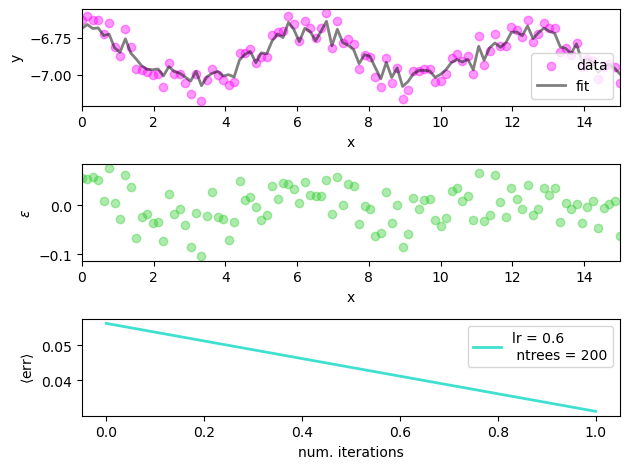

In [144]:
gboost(x, y, ntrees=200, lr=.6, tol=5e-2)

#### on this particular dataset, a high learning rate is perfectly fine. Overfitting cannot be avoided. Generally, a large number of trees might lead to better convergence, except it takes a long time. If we increase learning rate and raise number of trees, we might be in business.

## 3. XGBoost

#### In an ensemble methods with weak learners, some learners perform better than others and can be given greater weights. We want to improve with each iteration, so greater errors are areas where we can learn more and those are given more weight
#### An overview of how it works:
- initialize with some random, poor but quick to evaluate model, .e.g just a constant value. The goal of this model is to minimize loss
- compute residuals. Then fit to residuals
- evaluate hessian and gradients (differentiate loss wrt model). Same as a second order taylor expansion -- we get more precise with the hessians
- update to existing predictions
- repeat
#### XGBoost is often done with regularization. $\alpha$ and $\lambda$ are the L1 and L2 regularization terms.

C:\Users\ajati\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


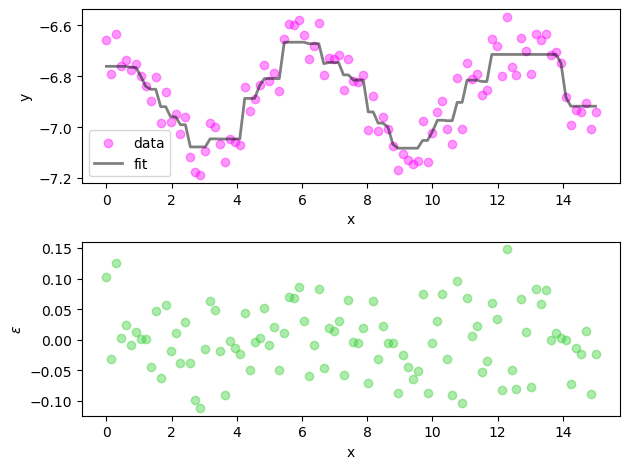

In [185]:
x = np.linspace(0, 15, 100)
y = np.array([.25*np.random.random() + .2 * np.cos(x_i) - 7. for x_i in x])

x = x.reshape(-1, 1)
y = y.ravel()  

dtrain = xgb.DMatrix(x, label=y) #this is XGBoost's internal data structure for computational efficiency

ntrees = 200
lr = 0.02
params = {'objective': 'reg:squarederror', 'booster': 'gbtree', 'learning_rate': lr, \
    'max_depth': 15, 'alpha': .2, 'lambda': .5, 'n_estimators': ntrees}
model = xgb.train(params, dtrain, num_boost_round=ntrees, early_stopping_rounds=30, evals=[(dtrain, 'train')], verbose_eval=False)

y_pred = model.predict(dtrain)
res = y - y_pred
err = np.mean(np.abs(res))

fig, axs = plt.subplots(2, sharex=False)

ax = axs[0]
ax.scatter(x, y, marker='o', alpha=0.4, color='fuchsia', label='data')
ax.plot(x, y_pred, color='k', linewidth=2, alpha=0.5, label='fit')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

ax = axs[1]
ax.scatter(x, res, marker='o', alpha=0.4, color='limegreen')
ax.set_xlabel('x')
ax.set_ylabel(r'$\epsilon$')


plt.tight_layout()
plt.show()


#### XGBoost shines most for large datasets, can be used for high dimensional data, and is versatile (both classification and regression). This is a simple dataset, and it just appears to be nothing more than glorified fitting on such a dataset considering the nature of the data, here